In [2]:
!pwd

/home/gdolle/code/G-Dolle/DIVVY_BIKE/notebooks


In [3]:
cd '/home/gdolle/code/G-Dolle/DIVVY_BIKE'

/home/gdolle/code/G-Dolle/DIVVY_BIKE


In [4]:
!pwd

/home/gdolle/code/G-Dolle/DIVVY_BIKE


In [5]:
%load_ext autoreload
%autoreload 2

In [5]:
import os
import pandas as pd
import numpy as np
import math
from datetime import date, time, datetime
import seaborn as sns

from ml_logic.data_import import get_weather_data, get_divvy_data
from ml_logic.cleaning import weather_cleaning, merge_divvy_weather, features_target
from ml_logic.preprocessor import transform_time_features, preprocess_features, target_process

from ml_logic.main import preprocess

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler

# Computing nb of departures and arrivals per hour for each station

## Nb of departures

In [7]:

quarter= os.environ.get("DIVVY_QUARTER")
year= os.environ.get("DIVVY_YEAR")


In [8]:


df = get_divvy_data(year,quarter)
df.head(2)


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,9DC7B962304CBFD8,electric_bike,2021-09-28 16:07:10,2021-09-28 16:09:54,NaN,NaN,NaN,NaN,41.89,-87.68,41.89,-87.67,casual
1,F930E2C6872D6B32,electric_bike,2021-09-28 14:24:51,2021-09-28 14:40:05,NaN,NaN,NaN,NaN,41.94,-87.64,41.98,-87.67,casual


In [9]:
df.start_station_name.value_counts()

Streeter Dr & Grand Ave               43006
Michigan Ave & Oak St                 22777
DuSable Lake Shore Dr & North Blvd    20214
Wells St & Concord Ln                 19964
Millennium Park                       19375
                                      ...  
California Ave & 36th St                  2
351                                       2
Sacramento Ave & Pershing Rd              1
Kildare Ave & Chicago Ave                 1
Archer Ave & 43rd St                      1
Name: start_station_name, Length: 769, dtype: int64

In [10]:

df['started_at']=pd.to_datetime(df['started_at'])
df['ended_at']=pd.to_datetime(df['ended_at'])
df['hourly_data_started'] = df.started_at.dt.round('60min')
df['hourly_data_ended'] = df.ended_at.dt.round('60min')


In [11]:

df_departures=df[[
                 "start_station_name",
                 "start_station_id",
                 "hourly_data_started"	]]

df_departures=df_departures.rename(columns={'hourly_data_started':'hourly_data',
                                            "start_station_name":"station_name",
                                            "start_station_id": "station_id"})

df_departures.head(2)

,station_name,station_id,hourly_data
0,NaN,NaN,2021-09-28 16:00:00
1,NaN,NaN,2021-09-28 14:00:00


In [12]:
df_departures["nb_departures"]=1

In [13]:

df_dep_agg=df_departures.groupby(by=["station_name",
                                        "station_id",
                                        'hourly_data']).count().reset_index()
df_dep_agg.head(10)


,station_name,station_id,hourly_data,nb_departures
0,2112 W Peterson Ave,KA1504000155,2021-07-01 06:00:00,1
1,2112 W Peterson Ave,KA1504000155,2021-07-01 09:00:00,1
2,2112 W Peterson Ave,KA1504000155,2021-07-01 10:00:00,1
3,2112 W Peterson Ave,KA1504000155,2021-07-01 15:00:00,2
4,2112 W Peterson Ave,KA1504000155,2021-07-01 20:00:00,1
5,2112 W Peterson Ave,KA1504000155,2021-07-02 07:00:00,1
6,2112 W Peterson Ave,KA1504000155,2021-07-02 09:00:00,1
7,2112 W Peterson Ave,KA1504000155,2021-07-02 11:00:00,2
8,2112 W Peterson Ave,KA1504000155,2021-07-02 12:00:00,1
9,2112 W Peterson Ave,KA1504000155,2021-07-02 21:00:00,1


In [14]:
from ml_logic.preprocessor import compute_geohash_stations

In [15]:
station_df = compute_geohash_stations(precision= 5)

/home/gdolle/code/G-Dolle/DIVVY_BIKE/ml_logic/preprocessor.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stations_reduced.rename(columns={"name":"station_name"}, inplace=True)


In [16]:
df_dep_agg_geohash = df_dep_agg.merge(station_df, how="left", on="station_name")

In [17]:
df_dep_agg_geohash

,station_name,station_id,hourly_data,nb_departures,geohash
0,2112 W Peterson Ave,KA1504000155,2021-07-01 06:00:00,1,dp3wu
1,2112 W Peterson Ave,KA1504000155,2021-07-01 09:00:00,1,dp3wu
2,2112 W Peterson Ave,KA1504000155,2021-07-01 10:00:00,1,dp3wu
3,2112 W Peterson Ave,KA1504000155,2021-07-01 15:00:00,2,dp3wu
4,2112 W Peterson Ave,KA1504000155,2021-07-01 20:00:00,1,dp3wu
...,...,...,...,...,...
578304,Yates Blvd & 93rd St,20237,2021-09-23 17:00:00,1,dp3tr
578305,Yates Blvd & 93rd St,20237,2021-09-25 22:00:00,1,dp3tr
578306,Yates Blvd & 93rd St,20237,2021-09-26 22:00:00,1,dp3tr
578307,Yates Blvd & 93rd St,20237,2021-09-27 20:00:00,1,dp3tr


In [21]:
df_dep_agg_geohash = df_dep_agg_geohash.drop(columns=["station_name","station_id"])

In [29]:
df_dep_final=df_dep_agg_geohash.groupby(by=["geohash",
                                        'hourly_data']).mean().reset_index()

In [32]:
df_dep_final.shape

(46474, 3)

In [33]:
def cleaning_divvy_gen_agg(df):

    df['started_at']=pd.to_datetime(df['started_at'])
    df['ended_at']=pd.to_datetime(df['ended_at'])
    df['hourly_data_started'] = df.started_at.dt.round('60min')
    df['hourly_data_ended'] = df.ended_at.dt.round('60min')

    df_departures=df[[
                    "start_station_name",
                    "start_station_id",
                    "hourly_data_started"]]

    df_departures=df_departures.rename(columns={'hourly_data_started':'hourly_data',
                                                "start_station_name":"station_name",
                                                "start_station_id": "station_id"})

    df_departures["nb_departures"]=1

    df_dep_agg=df_departures.groupby(by=["station_name",
                                        "station_id",
                                        'hourly_data']).count().reset_index()

    
    station_df = compute_geohash_stations(precision= 5)
    df_dep_agg_geohash = df_dep_agg.merge(station_df, how="left", on="station_name")
    df_dep_agg_geohash = df_dep_agg_geohash.drop(columns=["station_name","station_id"])
    df_dep_final=df_dep_agg_geohash.groupby(by=["geohash",
                                        'hourly_data']).mean().reset_index()

    df_arrivals=df[["end_station_name",
                 "end_station_id",
                 "hourly_data_ended"]]

    df_arrivals=df_arrivals.rename(columns={'hourly_data_ended':'hourly_data',
                                            "end_station_name":"station_name",
                                            "end_station_id": "station_id"})
    df_arrivals["nb_arrivals"]=1

    df_arr_agg=df_arrivals.groupby(by=["station_name",
                                            "station_id",
                                            'hourly_data']).count().reset_index()

    df_arr_agg_geohash = df_arr_agg.merge(station_df, how="left", on="station_name")
    df_arr_agg_geohash = df_arr_agg_geohash.drop(columns=["station_name","station_id"])
    df_arr_final=df_arr_agg_geohash.groupby(by=["geohash",
                                        'hourly_data']).mean().reset_index()

    merge_ratio=pd.merge(
    df_dep_final,
    df_arr_final,
    how="outer",
    on=['hourly_data',"geohash"])


    merge_ratio["nb_departures"] = merge_ratio["nb_departures"].replace(np.nan, 0)
    merge_ratio["nb_arrivals"] = merge_ratio["nb_arrivals"].replace(np.nan, 0)

    merge_ratio['ratio']=merge_ratio['nb_departures']/merge_ratio['nb_arrivals']

    return merge_ratio


In [34]:
test_df = cleaning_divvy_gen_agg(df)

/home/gdolle/code/G-Dolle/DIVVY_BIKE/ml_logic/preprocessor.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stations_reduced.rename(columns={"name":"station_name"}, inplace=True)


In [35]:
test_df.head(5)

,geohash,hourly_data,nb_departures,nb_arrivals,ratio
0,dp3sy,2021-07-01 04:00:00,1.0,1.0,1.0
1,dp3sy,2021-07-01 17:00:00,1.0,0.0,inf
2,dp3sy,2021-07-01 18:00:00,1.0,2.0,0.5
3,dp3sy,2021-07-01 21:00:00,1.0,0.0,inf
4,dp3sy,2021-07-01 23:00:00,4.0,1.0,4.0


In [36]:
test_df.shape

(52546, 5)

# Merging this consolidated Divvy dataset with Weather data

## Importing and cleaning Weather data

In [37]:
from ml_logic.data_import import get_weather_data
from ml_logic.cleaning import weather_cleaning

In [38]:
raw_weather_df = get_weather_data()
clean_weather_df = weather_cleaning(raw_weather_df)


In [39]:
clean_weather_df.head(2)

,dt_iso,temp,pressure,humidity,wind_speed,wind_deg,clouds_all,hourly_data
0,2013-01-01 00:00:00,-2.87,1018,68,4.12,300,100,2013-01-01 00:00:00
1,2013-01-01 01:00:00,-3.12,1019,69,3.10,310,100,2013-01-01 01:00:00


## Merging Weather and Divvy data

In [40]:
merged_df = merge_divvy_weather(test_df, clean_weather_df)
merged_df.shape

(52546, 12)

In [41]:
merged_df.head(5)

,geohash,hourly_data,nb_departures,nb_arrivals,ratio,dt_iso,temp,pressure,humidity,wind_speed,wind_deg,clouds_all
0,dp3sy,2021-07-01 04:00:00,1.0,1.0,1.0,2021-07-01 04:00:00,21.29,1001,84,0.00,0,75
1,dp3sy,2021-07-01 17:00:00,1.0,0.0,inf,2021-07-01 17:00:00,23.18,1018,62,7.20,20,20
2,dp3sy,2021-07-01 18:00:00,1.0,2.0,0.5,2021-07-01 18:00:00,23.36,1018,61,8.23,30,20
3,dp3sy,2021-07-01 21:00:00,1.0,0.0,inf,2021-07-01 21:00:00,22.44,1018,55,8.75,30,20
4,dp3sy,2021-07-01 23:00:00,4.0,1.0,4.0,2021-07-01 23:00:00,20.64,1019,62,7.72,40,20


# Getting features and target dataset (target = nb_arrivals)

In [42]:
target ="nb_arrivals"

In [43]:
X,y = features_target(merged_df, target)

In [44]:
X.head(2)

,geohash,hourly_data,dt_iso,temp,pressure,humidity,wind_speed,wind_deg,clouds_all
0,dp3sy,2021-07-01 04:00:00,2021-07-01 04:00:00,21.29,1001,84,0.0,0,75
1,dp3sy,2021-07-01 17:00:00,2021-07-01 17:00:00,23.18,1018,62,7.2,20,20


In [54]:
X.geohash.nunique()

44

In [45]:
y.head(2)

0    1.0
1    0.0
Name: nb_arrivals, dtype: float64

In [50]:
import math
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
import pygeohash as gh
from ml_logic.data_import import get_station_data


def transform_time_features(X: pd.DataFrame) -> np.ndarray:

    assert isinstance(X, pd.DataFrame)
    hourly_data = pd.to_datetime(X["hourly_data"],
                            format="%Y-%m-%d %H:%M:%S UTC",
                            utc=True)
    hourly_data = hourly_data.dt.tz_convert("America/Chicago").dt
    dow = hourly_data.weekday
    hour = hourly_data.hour
    month = hourly_data.month
    #year = hourly_data.year
    hour_sin = np.sin(2 * math.pi / 24 * hour)
    hour_cos = np.cos(2 * math.pi / 24 * hour)

    result = np.stack([hour_sin, hour_cos, dow, month], axis=1)
    return result

def preprocess_features(X: pd.DataFrame) -> np.ndarray:

    def create_sklearn_preprocessor() -> ColumnTransformer:

        time_categories = {
                    0: np.arange(0, 7, 1),  # days of the week
                    1: np.arange(1, 13, 1)  # months of the year
                    # will need to add one cat for the year when generalizing
                }

        time_pipe = make_pipeline(
                FunctionTransformer(transform_time_features),
                make_column_transformer(
                    (OneHotEncoder(
                        categories=time_categories,
                        sparse=False,
                        handle_unknown="ignore"), [2,3]), # correspond to columns ["day of week", "month"], not the others columns
                    #(FunctionTransformer(lambda year: (year-year_min)/(year_max-year_min)), [4]), # min-max scale the columns 4 ["year"]
                    remainder="passthrough" # keep hour_sin and hour_cos
                    )
                )

        weather_pipe = make_pipeline(StandardScaler())
        weather_features = ["temp","pressure","humidity","wind_speed","wind_deg","clouds_all"]

        cat_transformer = OneHotEncoder(sparse=False, handle_unknown="ignore")

        final_preprocessor = ColumnTransformer(
                    [
                        ("time_preproc", time_pipe, ["hourly_data"]),
                        ("weather_scaler",weather_pipe, weather_features),
                         ("geohash encoding", cat_transformer,["geohash"])
                    ],
                    n_jobs=-1,
                )
        return final_preprocessor


    preprocessor = create_sklearn_preprocessor()

    X = X.drop(columns=["dt_iso"])

    X_processed = preprocessor.fit_transform(X)

    X_processed_df = pd.DataFrame(X_processed)

    return preprocessor, X_processed_df


In [51]:
preprocessor, X_processed_df = preprocess_features(X)

In [52]:
X_processed_df.shape

(52546, 71)

In [53]:
X_processed_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,61,62,63,64,65,66,67,68,69,70
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [307]:
import os
import pandas as pd
import numpy as np
import math

from ml_logic.data_import import get_weather_data, get_divvy_data
from ml_logic.cleaning import compute_geohash_stations,weather_cleaning, cleaning_divvy_gen,cleaning_divvy_gen_agg, merge_divvy_weather, features_target
from ml_logic.preprocessor import transform_time_features, preprocess_features, target_process

In [308]:
from ml_logic.main import preprocess, preprocess_test

In [309]:
target_chosen = "nb_arrivals"
X_processed_df, y_processed_df, preprocessor = preprocess(target_chosen)


Raw data imported


/home/gdolle/code/G-Dolle/DIVVY_BIKE/ml_logic/cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stations_reduced.rename(columns={"name":"station_name"}, inplace=True)


Data cleaned and merged
features and target dataframes created
features preprocessed
nb_arrivals picked as target
Preprocessing of Training set is done


In [13]:
X_processed_df.shape

(52546, 71)

In [14]:
X_processed_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,61,62,63,64,65,66,67,68,69,70
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
y_processed_df.head(2)

0    1.0
1    0.0
Name: nb_arrivals, dtype: float64

In [16]:
X_test_processed, y_test_processed=preprocess_test(preprocessor, target_chosen)

Test Raw data imported


/home/gdolle/code/G-Dolle/DIVVY_BIKE/ml_logic/cleaning.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stations_reduced.rename(columns={"name":"station_name"}, inplace=True)


Test Data cleaned and merged
Test features and target dataframes created
nb_arrivals picked as target
Preprocessing of test set is done


In [20]:
pd.DataFrame(X_test_processed).shape

(44841, 71)

In [21]:
pd.DataFrame(X_test_processed).head(2)

,0,1,2,3,4,5,6,7,8,9,...,61,62,63,64,65,66,67,68,69,70
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
y_test_processed.head(2)

0    0.0
1    0.0
Name: nb_arrivals, dtype: float64

In [23]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import learning_curve, GridSearchCV

In [24]:
X_train,X__val,y_train,y_val=train_test_split(X_processed_df,
                                                             y_processed_df,
                                                             test_size=0.2,
                                                             random_state=1)


In [27]:
model_lr=KNeighborsRegressor()
cv_results=cross_validate(model_lr,X_train,y_train,
                          cv=5,scoring=('r2','neg_mean_squared_error'))

In [28]:
r2_lr=round(cv_results['test_r2'].mean(),5)
mse_lr=round(cv_results['test_neg_mean_squared_error'].mean(),5)
r2_lr,mse_lr

(0.35712, -2.37025)

In [29]:
import tpot
model = tpot.TPOTRegressor(generations=10,
                           population_size=5,
                           scoring='neg_mean_squared_error',
                           verbosity=2,
                          n_jobs=-1)



/home/gdolle/.pyenv/versions/DIVVY_BIKE/lib/python3.10/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [30]:
model.fit(X_processed_df, y_processed_df)

Optimization Progress:   0%|          | 0/55 [00:00<?, ?pipeline/s]

/home/gdolle/.pyenv/versions/DIVVY_BIKE/lib/python3.10/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/home/gdolle/.pyenv/versions/DIVVY_BIKE/lib/python3.10/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/home/gdolle/.pyenv/versions/DIVVY_BIKE/lib/python3.10/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/home/gdolle/.pyenv/versions/DIVVY_BIKE/lib/python3.10/site-packages/tpot/builtins/__

                                                                              
Generation 1 - Current best internal CV score: -2.3663731884837294
Optimization Progress:  20%|██        | 11/55 [05:55<13:47, 18.82s/pipeline]

/home/gdolle/.pyenv/versions/DIVVY_BIKE/lib/python3.10/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/home/gdolle/.pyenv/versions/DIVVY_BIKE/lib/python3.10/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/home/gdolle/.pyenv/versions/DIVVY_BIKE/lib/python3.10/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/home/gdolle/.pyenv/versions/DIVVY_BIKE/lib/python3.10/site-packages/tpot/builtins/__

                                                                            
Generation 2 - Current best internal CV score: -2.3663667732849754
Optimization Progress:  29%|██▉       | 16/55 [07:49<11:59, 18.45s/pipeline]

/home/gdolle/.pyenv/versions/DIVVY_BIKE/lib/python3.10/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/home/gdolle/.pyenv/versions/DIVVY_BIKE/lib/python3.10/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/home/gdolle/.pyenv/versions/DIVVY_BIKE/lib/python3.10/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/home/gdolle/.pyenv/versions/DIVVY_BIKE/lib/python3.10/site-packages/tpot/builtins/__

                                                                            
Generation 3 - Current best internal CV score: -2.3663667732849754
Optimization Progress:  38%|███▊      | 21/55 [08:55<07:48, 13.79s/pipeline]

/home/gdolle/.pyenv/versions/DIVVY_BIKE/lib/python3.10/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/home/gdolle/.pyenv/versions/DIVVY_BIKE/lib/python3.10/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


                                                                            
Generation 4 - Current best internal CV score: -2.362048241899395
                                                                            
Generation 5 - Current best internal CV score: -2.0726198816460526
                                                                            
Generation 6 - Current best internal CV score: -2.0726198816460526
                                                                            
Generation 7 - Current best internal CV score: -2.0726198816460526
                                                                            
Generation 8 - Current best internal CV score: -2.0726198816460526
                                                                            
Generation 9 - Current best internal CV score: -1.7251228146053807
                                                                            
Generation 10 - Current best internal CV score: -1.725122814

TPOTRegressor(generations=10, n_jobs=-1, population_size=5,
              scoring='neg_mean_squared_error', verbosity=2)

In [ ]:
model.score(X_test_processed, y_test_processed)

# Encoding of station_name

In [76]:
from sklearn.preprocessing import OneHotEncoder

In [77]:
X.station_name.nunique()

847

In [81]:
ohe = OneHotEncoder(sparse = False)
ohe.fit(X[['station_name']])

OneHotEncoder(sparse=False)

In [82]:
X_encoded = ohe.transform(X[["station_name"]])

In [83]:
X[ohe.categories_[0]] = X_encoded

In [84]:
X = X.drop("station_name", axis=1)

In [85]:
X.shape

(344946, 856)

In [45]:
features_df_complete, target_df = features_target(merged_df,target)

In [46]:
features_df_complete.head(2)

,station_name,station_id,hourly_data,dt_iso,temp,pressure,humidity,wind_speed,wind_deg,clouds_all
0,2112 W Peterson Ave,KA1504000155,2022-01-01 21:00:00,2022-01-01 21:00:00,-0.75,1010,93,4.92,20,100
1,2112 W Peterson Ave,KA1504000155,2022-01-03 18:00:00,2022-01-03 18:00:00,-6.55,1030,49,3.13,253,0


In [47]:
features_df_complete.shape

(344946, 10)

In [60]:
import pygeohash as gh
from ml_logic.data_import import get_station_data


def compute_geohash_stations(precision: int = 5) -> np.ndarray:
    """
    Add a geohash (ex: “dr5rx”) of len “precision” = 5 by default
    corresponding to each (lon,lat) tuple, for pick-up, and drop-off
    """
            
    df_stations=get_station_data()
    assert isinstance(df_stations, pd.DataFrame)
    df_stations["geohash"] = df_stations.apply(lambda x: gh.encode(
        x.lat, x.lon, precision=precision),
                                    axis=1)
    df_stations_reduced=df_stations[["name","geohash"]]
    df_stations_reduced.rename(columns={"name":"station_name"}, inplace=True)
    return df_stations_reduced


In [61]:
# Calling Geohash function and creating Stations Dataframe
df_stations_reduced=compute_geohash_stations(precision=5)


/tmp/ipykernel_16004/110657374.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stations_reduced.rename(columns={"name":"station_name"}, inplace=True)


In [62]:
df_stations_reduced.geohash.nunique()

47

In [59]:
df_stations_reduced[df_stations_reduced["station_name"]=="2112 W Peterson Ave"]

,station_name,station_id,geohash
224,2112 W Peterson Ave,456,dp3wu


In [124]:
df_stations_reduced.head(5)

,station_name,geohash
0,Central Ave & Harrison St,dp3w4
1,Halsted St & 59th St,dp3tt
2,Damen Ave & 51st St,dp3tu
3,Halsted St & 21st St,dp3wj
4,Michigan Ave & Madison St,dp3wq


In [63]:
# Merge divvy data & station data
X_complete=features_df_complete.merge(df_stations_reduced,how="left",on=["station_name"])
X_complete.head(5)

,station_name,station_id,hourly_data,dt_iso,temp,pressure,humidity,wind_speed,wind_deg,clouds_all,geohash
0,2112 W Peterson Ave,KA1504000155,2022-01-01 21:00:00,2022-01-01 21:00:00,-0.75,1010,93,4.92,20,100,dp3wu
1,2112 W Peterson Ave,KA1504000155,2022-01-03 18:00:00,2022-01-03 18:00:00,-6.55,1030,49,3.13,253,0,dp3wu
2,2112 W Peterson Ave,KA1504000155,2022-01-04 11:00:00,2022-01-04 11:00:00,-5.02,1021,79,4.12,190,40,dp3wu
3,2112 W Peterson Ave,KA1504000155,2022-01-04 18:00:00,2022-01-04 18:00:00,-0.39,1017,70,4.02,204,99,dp3wu
4,2112 W Peterson Ave,KA1504000155,2022-01-10 09:00:00,2022-01-10 09:00:00,-10.37,1034,58,2.24,301,98,dp3wu


In [69]:
X_complete = X_complete.drop(columns=["station_name","station_id","dt_iso"])

In [70]:
time_categories = {
                    0: np.arange(0, 7, 1),  # days of the week
                    1: np.arange(1, 13, 1)  # months of the year
                    # will need to add one cat for the year when generalizing
                }

time_pipe = make_pipeline(
    FunctionTransformer(transform_time_features),
    make_column_transformer(
        (OneHotEncoder(
            categories=time_categories,
            sparse=False,
            handle_unknown="ignore"), [2,3]), # correspond to columns ["day of week", "month"], not the others columns
        #(FunctionTransformer(lambda year: (year-year_min)/(year_max-year_min)), [4]), # min-max scale the columns 4 ["year"]
        remainder="passthrough" # keep hour_sin and hour_cos
        )
    )

weather_pipe = make_pipeline(StandardScaler())
weather_features = ["temp","pressure","humidity","wind_speed","wind_deg","clouds_all"]


cat_transformer = OneHotEncoder(sparse=False)

final_preprocessor = ColumnTransformer(
        [
            ("time_preproc", time_pipe, ["hourly_data"]),
            ("weather_scaler",weather_pipe, weather_features),
            ("geohash encoding", cat_transformer,["geohash"])
        ],
        n_jobs=-1,
    )

In [71]:
X_processed = final_preprocessor.fit_transform(X_complete)

X_processed_df = pd.DataFrame(X_processed)

In [72]:
X_processed_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [125]:
import os
import pandas as pd
import numpy as np
import math

from ml_logic.data_import import get_weather_data, get_divvy_data
from ml_logic.cleaning import weather_cleaning, cleaning_divvy_gen, merge_divvy_weather, features_target
from ml_logic.preprocessor import transform_time_features, preprocess_features, target_process, compute_geohash_stations


from ml_logic.main import preprocess, preprocess_test

In [117]:
X_processed_df, y_processed_df, preprocessor, df_stations_reduced = preprocess("nb_arrivals")
X_test_processed, y_test_processed=preprocess_test(preprocessor, "nb_arrivals", df_stations_reduced)

Raw data imported
Data cleaned and merged
features and target dataframes created
Geohash of stations computed
Geohash of stations added to Features dataframe


/home/gdolle/code/G-Dolle/DIVVY_BIKE/ml_logic/preprocessor.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stations_reduced.rename(columns={"name":"station_name"}, inplace=True)


features preprocessed
nb_arrivals picked as target
Preprocessing of Training set is done


In [118]:
X_processed_df.shape

(344946, 74)

In [119]:
X_processed_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [120]:
X_test_processed, y_test_processed=preprocess_test(preprocessor, "nb_arrivals", df_stations_reduced)

Test Raw data imported
Test Data cleaned and merged
Test features and target dataframes created
nb_arrivals picked as target
Preprocessing of test set is done


In [121]:
X_test_processed.shape

(659944, 74)

In [123]:
pd.DataFrame(X_test_processed).head(2)

,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
quarter= os.environ.get("DIVVY_QUARTER_TEST")
year= os.environ.get("DIVVY_YEAR_TEST")

raw_divvy_df = get_divvy_data(year,quarter)
raw_weather_df = get_weather_data()


In [102]:
clean_divvy_df = cleaning_divvy_gen(raw_divvy_df)
clean_weather_df = weather_cleaning(raw_weather_df)

merged_df_test = merge_divvy_weather(clean_divvy_df, clean_weather_df)

In [103]:
X_test, y_test = features_target(merged_df_test, "nb_arrivals")

In [104]:
X_complete=X_test.merge(df_stations_reduced,how="left",on=["station_name"])

In [105]:
X_complete.head(2)

,station_name,station_id,hourly_data,dt_iso,temp,pressure,humidity,wind_speed,wind_deg,clouds_all,geohash
0,111th St - Morgan Park Metra,682,2022-05-09 17:00:00,2022-05-09 17:00:00,23.11,1013,51,7.72,160,75,NaN
1,111th St - Morgan Park Metra,682,2022-05-12 18:00:00,2022-05-12 18:00:00,32.62,1018,43,7.72,170,20,NaN


In [107]:
X_complete.geohash.unique()

array([nan, 'dp3wu', 'dp3tx', 'dp3wj', 'dp3wm', 'dp3tj', 'dp3wn', 'dp3wh',
       'dp3ws', 'dp3wk', 'dp3sy', 'dp3tu', 'dp3tv', 'dp3tt', 'dp3wt',
       'dp3w7', 'dp3w6', 'dp3v0', 'dp3sz', 'dp3we', 'dp3tr', 'dp3xh',
       'dp3tp', 'dp3ty', 'dp3w3', 'dp3xj', 'dp3wv', 'dp3v2', 'dp3ts',
       'dp3tw', 'dp3w4', 'dp3wd', 'dp3w5', 'dp3xk', 'dp3tq', 'dp3wq',
       'dp3tn', 'dp3tm', 'dp3te', 'dp3w9', 'dp3th', 'dp3tg', 'dp3x7',
       'dp3tz', 'dp3wg', 'dp3t7', 'dp3tk'], dtype=object)

In [108]:
X_complete.geohash.replace(np.nan, "aaa", inplace=True)

In [109]:
X_complete.geohash.unique()

array(['aaa', 'dp3wu', 'dp3tx', 'dp3wj', 'dp3wm', 'dp3tj', 'dp3wn',
       'dp3wh', 'dp3ws', 'dp3wk', 'dp3sy', 'dp3tu', 'dp3tv', 'dp3tt',
       'dp3wt', 'dp3w7', 'dp3w6', 'dp3v0', 'dp3sz', 'dp3we', 'dp3tr',
       'dp3xh', 'dp3tp', 'dp3ty', 'dp3w3', 'dp3xj', 'dp3wv', 'dp3v2',
       'dp3ts', 'dp3tw', 'dp3w4', 'dp3wd', 'dp3w5', 'dp3xk', 'dp3tq',
       'dp3wq', 'dp3tn', 'dp3tm', 'dp3te', 'dp3w9', 'dp3th', 'dp3tg',
       'dp3x7', 'dp3tz', 'dp3wg', 'dp3t7', 'dp3tk'], dtype=object)

In [106]:
df_stations_reduced[df_stations_reduced["station_name"]=="111th St - Morgan Park Metra"]

,station_name,geohash


In [115]:
X_test_processed = preprocessor.transform(X_complete)

In [2]:
pwd

'/home/gdolle/code/G-Dolle/DIVVY_BIKE/notebooks'

In [3]:
cd '/home/gdolle/code/G-Dolle/DIVVY_BIKE'

/home/gdolle/code/G-Dolle/DIVVY_BIKE


In [4]:
import os
import pandas as pd
import numpy as np
import math

from ml_logic.data_import import get_weather_data, get_divvy_data
from ml_logic.cleaning import weather_cleaning, cleaning_divvy_gen, merge_divvy_weather, features_target
from ml_logic.preprocessor import transform_time_features, preprocess_features, target_process, compute_geohash_stations


from ml_logic.main import preprocess, preprocess_test

In [6]:
X_processed_df, y_processed_df, preprocessor, df_stations_reduced = preprocess("nb_arrivals")

Raw data imported
Data cleaned and merged
features and target dataframes created
Geohash of stations computed
Geohash of stations added to Features dataframe


/home/gdolle/code/G-Dolle/DIVVY_BIKE/ml_logic/preprocessor.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stations_reduced.rename(columns={"name":"station_name"}, inplace=True)


features preprocessed
nb_arrivals picked as target
Preprocessing of Training set is done


In [7]:
X_processed_df.shape

(718651, 72)

In [8]:
X_test_processed, y_test_processed=preprocess_test(preprocessor, "nb_arrivals", df_stations_reduced)

Test Raw data imported
Test Data cleaned and merged
Test features and target dataframes created
nb_arrivals picked as target
Preprocessing of test set is done


In [9]:
X_test_processed.shape

(539439, 72)

In [36]:
from folium import Map,plugins

#m = folium.Map([41.8781, -87.6298], zoom_start=11)

In [39]:
from ml_logic.data_import import get_station_data

stations_df = get_station_data()

In [41]:
stations_df[["name","lat","lon"]].head(5)

,name,lat,lon
0,Central Ave & Harrison St,41.872993,-87.764499
1,Halsted St & 59th St,41.787539,-87.644874
2,Damen Ave & 51st St,41.800908,-87.674684
3,Halsted St & 21st St,41.853780,-87.646603
4,Michigan Ave & Madison St,41.882134,-87.625125


In [120]:
stations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1422 entries, 0 to 1421
Data columns (total 24 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Unnamed: 0                            1422 non-null   int64  
 1   external_id                           1422 non-null   object 
 2   station_id                            1422 non-null   object 
 3   short_name                            684 non-null    object 
 4   eightd_has_key_dispenser              1422 non-null   bool   
 5   legacy_id                             1422 non-null   object 
 6   electric_bike_surcharge_waiver        1422 non-null   bool   
 7   capacity                              1422 non-null   int64  
 8   has_kiosk                             1422 non-null   bool   
 9   rental_methods                        684 non-null    object 
 10  name                                  1422 non-null   object 
 11  lon              

<AxesSubplot: xlabel='capacity', ylabel='Count'>

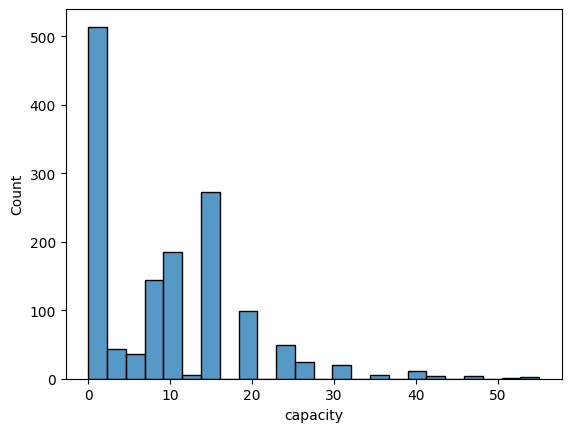

In [122]:
sns.histplot(stations_df["capacity"])

In [123]:
stations_df["capacity"].value_counts()

1     352
15    269
11    175
2     161
9     122
19     97
23     49
3      31
6      30
27     24
31     19
7      15
4      13
39     11
10     10
8       7
12      6
35      6
5       6
47      4
43      4
16      3
55      3
20      2
32      1
51      1
0       1
Name: capacity, dtype: int64

In [44]:
from folium import Map,plugins, Marker

m = Map(location=[41.8781, -87.6298], zoom_start=12)
m

In [48]:
tooltip_test = "Click Here For More Info"

In [50]:
marker = Marker(
    location=[41.872993, -87.764499],
    popup="<stong>Test pop up</stong>",
    tooltip=tooltip_test)
marker.add_to(m)

m

In [51]:
quarter= os.environ.get("DIVVY_QUARTER")
year= os.environ.get("DIVVY_YEAR")



In [52]:
df = get_divvy_data(year, quarter)
hourly_rides_df = cleaning_divvy_gen(df)

In [53]:
hourly_rides_df.shape

(718651, 6)

In [54]:
hourly_rides_df.station_name.value_counts()

Broadway & Cornelia Ave                 2039
Broadway & Waveland Ave                 2031
Broadway & Barry Ave                    2020
Clark St & Elm St                       2019
Wabash Ave & Grand Ave                  2016
                                        ... 
351                                        2
Archer Ave & 43rd St                       2
Sacramento Ave & Pershing Rd               1
DIVVY CASSETTE REPAIR MOBILE STATION       1
S Wentworth Ave & W 111th St               1
Name: station_name, Length: 770, dtype: int64

In [58]:
stations_df.loc[stations_df["name"]=="Broadway & Cornelia Ave",["lat","lon"]]

,lat,lon
598,41.945529,-87.646439


In [59]:
marker_2 = Marker(
    location=[41.945529, -87.646439],
    popup="<stong>Test pop up</stong>",
    tooltip=tooltip_test)
marker_2.add_to(m)

m

In [60]:
hourly_rides_df[hourly_rides_df["station_name"]=="Broadway & Cornelia Ave"]

,station_name,station_id,hourly_data,nb_departures,nb_arrivals,ratio
41954,Broadway & Cornelia Ave,13278,2021-07-01 01:00:00,1.0,2.0,0.5
41955,Broadway & Cornelia Ave,13278,2021-07-01 02:00:00,2.0,0.0,inf
41956,Broadway & Cornelia Ave,13278,2021-07-01 03:00:00,1.0,1.0,1.0
41957,Broadway & Cornelia Ave,13278,2021-07-01 06:00:00,1.0,1.0,1.0
41958,Broadway & Cornelia Ave,13278,2021-07-01 07:00:00,3.0,2.0,1.5
...,...,...,...,...,...,...
589561,Broadway & Cornelia Ave,13278,2021-09-24 02:00:00,0.0,2.0,0.0
589562,Broadway & Cornelia Ave,13278,2021-09-24 06:00:00,0.0,3.0,0.0
589563,Broadway & Cornelia Ave,13278,2021-09-25 03:00:00,0.0,2.0,0.0
589564,Broadway & Cornelia Ave,13278,2021-09-27 02:00:00,0.0,3.0,0.0


In [84]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


<AxesSubplot: xlabel='nb_departures', ylabel='Count'>

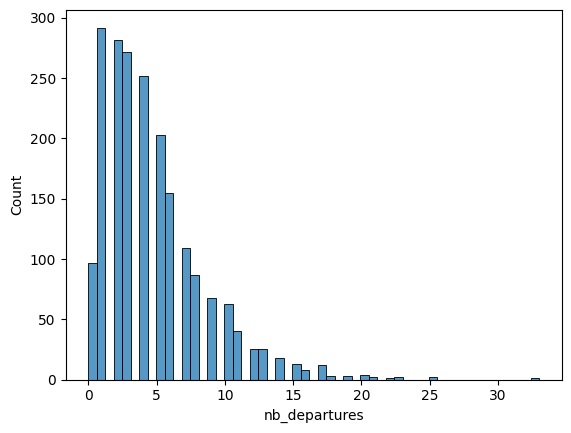

In [81]:
sns.histplot(hourly_rides_df[hourly_rides_df["station_name"]=="Broadway & Cornelia Ave"]["nb_departures"])

<AxesSubplot: xlabel='nb_arrivals', ylabel='Count'>

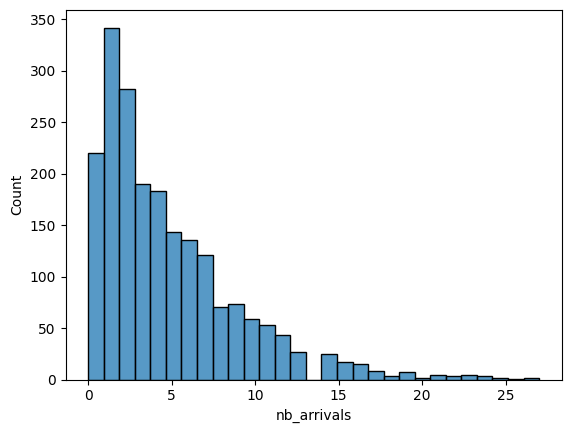

In [82]:
sns.histplot(hourly_rides_df[hourly_rides_df["station_name"]=="Broadway & Cornelia Ave"]["nb_arrivals"])

In [87]:
hourly_rides_df_red = hourly_rides_df[hourly_rides_df["station_name"]=="Broadway & Cornelia Ave"]

In [116]:
condition_hour_1 = (hourly_rides_df_red["hourly_data"]>=pd.to_datetime("2021-09-01 00:00:00"))
condition_hour_2 = (hourly_rides_df_red["hourly_data"]<=pd.to_datetime("2021-09-30 00:00:00"))
                  
                #  &
                #hourly_rides_df_red["hourly_data"]<=pd.to_datetime("2021-09-08 23:00:00"))



test_hour_df = hourly_rides_df_red[condition_hour_1]
test_hour_df = test_hour_df[condition_hour_2]

/tmp/ipykernel_26601/986273273.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_hour_df = test_hour_df[condition_hour_2]


In [117]:
test_hour_df.shape

(640, 6)

In [118]:
test_hour_df=test_hour_df.sort_values(by='hourly_data')

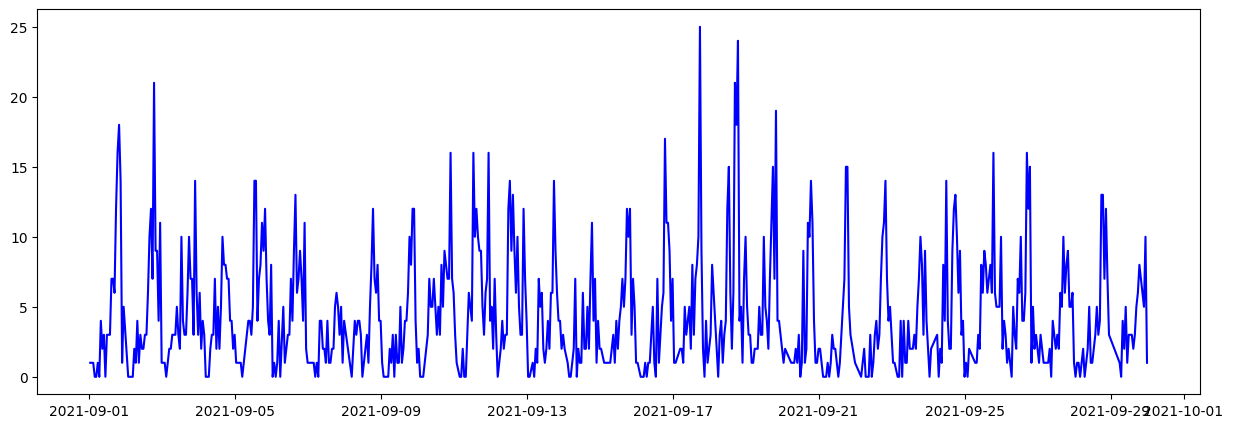

In [143]:
fig = plt.figure(figsize=(15, 5))
#fig.set(xlabel='', ylabel='Total # of trips started')
plt.plot(test_hour_df["hourly_data"], test_hour_df.nb_arrivals, color='b')
#ax1.plot(df["timestamp"], df.Registered, color='b')

#ax1.xaxis.set(
    #major_locator=mdates.DayLocator(),
    #major_formatter=mdates.DateFormatter("\n\n%A"),
    #minor_locator=mdates.HourLocator((0, 12)),
    #minor_formatter=mdates.DateFormatter("%H"),
#)
plt.show()

In [61]:
hourly_rides_df.nb_departures.value_counts()

1.0      205330
0.0      140342
2.0      112005
3.0       70890
4.0       48493
          ...  
99.0          1
120.0         1
109.0         1
98.0          1
101.0         1
Name: nb_departures, Length: 119, dtype: int64

In [62]:
hourly_rides_df[hourly_rides_df["hourly_data"]==pd.to_datetime("2021-09-30 08:00:00")]

,station_name,station_id,hourly_data,nb_departures,nb_arrivals,ratio
3535,Aberdeen St & Jackson Blvd,13157,2021-09-30 08:00:00,5.0,3.0,1.666667
4988,Aberdeen St & Monroe St,13156,2021-09-30 08:00:00,7.0,2.0,3.500000
6461,Aberdeen St & Randolph St,18062,2021-09-30 08:00:00,4.0,2.0,2.000000
7886,Ada St & Washington Blvd,13353,2021-09-30 08:00:00,3.0,3.0,1.000000
9179,Adler Planetarium,13431,2021-09-30 08:00:00,1.0,0.0,inf
...,...,...,...,...,...,...
710843,Western Ave & Congress Pkwy,15668,2021-09-30 08:00:00,0.0,2.0,0.000000
712698,Western Ave & Lunt Ave,RP-005,2021-09-30 08:00:00,0.0,1.0,0.000000
715098,Winchester Ave & Elston Ave,KA1504000140,2021-09-30 08:00:00,0.0,2.0,0.000000
715814,Wolcott (Ravenswood) Ave & Montrose Ave,TA1307000144,2021-09-30 08:00:00,0.0,2.0,0.000000


In [74]:
condition_hour = hourly_rides_df["hourly_data"]==pd.to_datetime("2021-09-30 18:00:00")

In [133]:
cond = hourly_rides_df['station_name'].str.contains('California').any()

In [136]:
hourly_rides_df.loc[cond==True,'station_name']

KeyError: True

In [138]:
stations_df_red = stations_df[["name","capacity"]]
stations_df_red.rename(columns={"name":"station_name"}, inplace=True)
stations_df_red

/tmp/ipykernel_26601/738833263.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations_df_red.rename(columns={"name":"station_name"}, inplace=True)


,station_name,capacity
0,Central Ave & Harrison St,11
1,Halsted St & 59th St,11
2,Damen Ave & 51st St,7
3,Halsted St & 21st St,11
4,Michigan Ave & Madison St,19
...,...,...
1417,Public Rack - Rockwell & Division,1
1418,Public Rack - Oakley Ave & 50th Pl,1
1419,Lamon Ave & Belmont Ave,9
1420,Public Rack - Racine Ave & 76th,2


In [139]:
hourly_rides_df = hourly_rides_df.merge(stations_df_red, how="left", on="station_name")

In [140]:
hourly_rides_df.capacity.value_counts()

15.0    261033
19.0    151875
23.0     77211
11.0     76411
27.0     40777
31.0     33042
39.0     17892
35.0     10088
47.0      7139
43.0      7042
55.0      4438
9.0       3867
7.0       2292
8.0       1923
6.0       1285
51.0      1185
10.0       145
12.0       101
1.0         54
3.0         30
0.0         22
4.0          6
5.0          1
Name: capacity, dtype: int64

In [142]:
hourly_rides_df.loc[hourly_rides_df.capacity==1,"station_name"].value_counts()

Komensky Ave & 31st St    45
Western Ave & 62nd St      9
Name: station_name, dtype: int64

/tmp/ipykernel_26601/977853560.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_hour_df = test_hour_df[condition_hour_2]


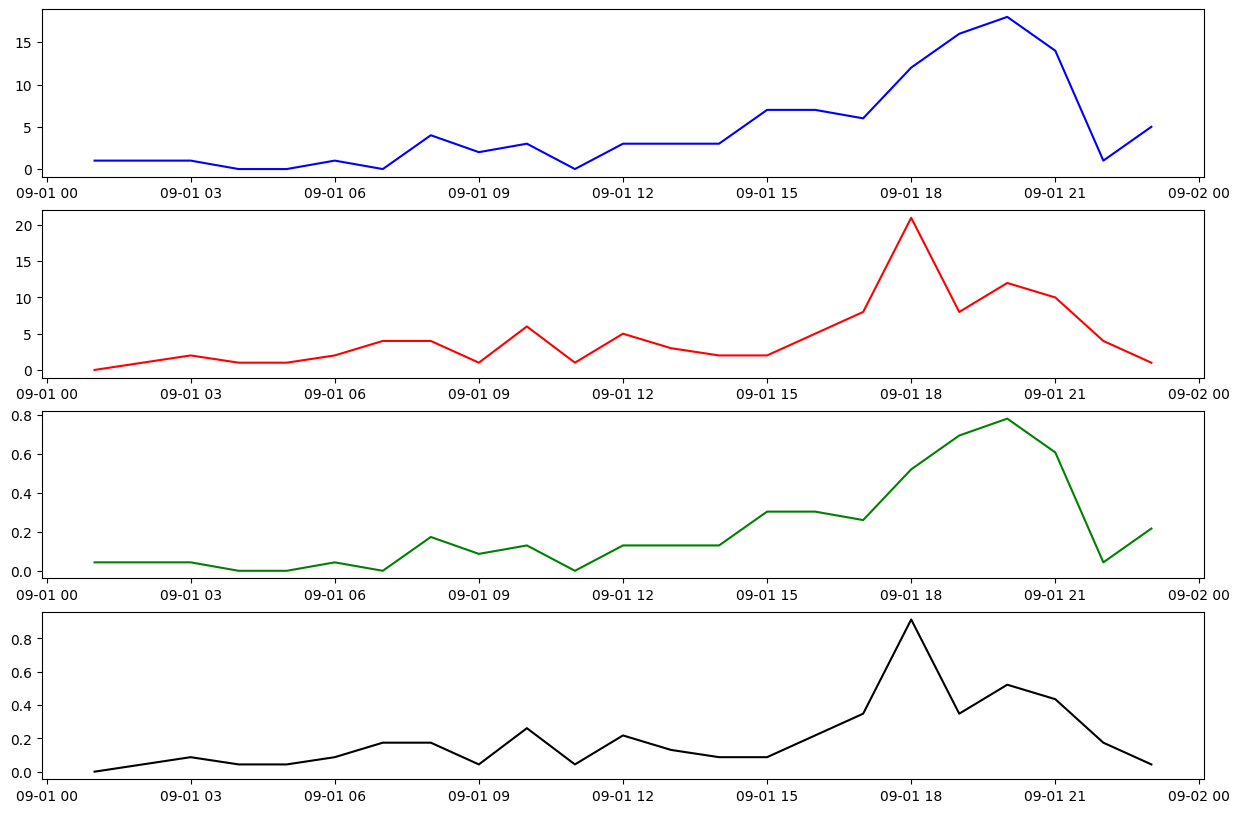

In [170]:
hourly_rides_df_red = hourly_rides_df[hourly_rides_df["station_name"]=="Broadway & Cornelia Ave"]

condition_hour_1 = (hourly_rides_df_red["hourly_data"]>=pd.to_datetime("2021-09-01 00:00:00"))
condition_hour_2 = (hourly_rides_df_red["hourly_data"]<=pd.to_datetime("2021-09-02 00:00:00"))

test_hour_df = hourly_rides_df_red[condition_hour_1]
test_hour_df = test_hour_df[condition_hour_2]

test_hour_df=test_hour_df.sort_values(by='hourly_data', ascending=True)

test_hour_df["arrivals_capa"] = test_hour_df.nb_arrivals/test_hour_df.capacity
test_hour_df["departures_capa"] = test_hour_df.nb_departures/test_hour_df.capacity


fig = plt.figure(figsize=(15, 10))

plt.subplot(4,1,1)
#fig.set(xlabel='', ylabel='Total # of trips started')
plt.plot(test_hour_df["hourly_data"], test_hour_df.nb_arrivals, color='b')
plt.subplot(4,1,2)
plt.plot(test_hour_df["hourly_data"], test_hour_df.nb_departures, color='r')
plt.subplot(4,1,3)
plt.plot(test_hour_df["hourly_data"], test_hour_df.arrivals_capa, color='g')
plt.subplot(4,1,4)
plt.plot(test_hour_df["hourly_data"], test_hour_df.departures_capa, color='k')


#ax1.plot(test_hour_df["hourly_data"], test_hour_df.nb_departures, color='r')

#ax1.xaxis.set(
    #major_locator=mdates.DayLocator(),
    #major_formatter=mdates.DateFormatter("\n\n%A"),
    #minor_locator=mdates.HourLocator((0, 12)),
    #minor_formatter=mdates.DateFormatter("%H"),
#)
plt.show()

In [168]:
test_hour_df.hourly_data.value_counts()

2021-09-01 01:00:00    1
2021-09-20 12:00:00    1
2021-09-20 14:00:00    1
2021-09-20 15:00:00    1
2021-09-20 16:00:00    1
                      ..
2021-09-11 00:00:00    1
2021-09-11 01:00:00    1
2021-09-11 02:00:00    1
2021-09-11 04:00:00    1
2021-10-01 00:00:00    1
Name: hourly_data, Length: 662, dtype: int64

In [229]:
stations_df = get_station_data()
stations_df_red = stations_df[["short_name","lat","lon","capacity"]]
stations_df_red.rename(columns={"short_name":"station_id"}, inplace=True)


/tmp/ipykernel_26601/1015058656.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations_df_red.rename(columns={"short_name":"station_id"}, inplace=True)


In [234]:
df = get_divvy_data(year, quarter)
hourly_rides_df = cleaning_divvy_gen(df)

In [235]:
stations_df_red.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1422 entries, 0 to 1421
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   station_id  684 non-null    object 
 1   lat         1422 non-null   float64
 2   lon         1422 non-null   float64
 3   capacity    1422 non-null   int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 44.6+ KB


In [236]:
stations_df_red.lon.isnull().values.any()

False

In [237]:
hourly_rides_df.station_id.value_counts()

13278                                   2039
13325                                   2031
13137                                   2020
TA1307000039                            2019
TA1307000117                            2016
                                        ... 
389                                        3
341                                        2
DIVVY CASSETTE REPAIR MOBILE STATION       1
339                                        1
20128                                      1
Name: station_id, Length: 762, dtype: int64

In [238]:
hourly_rides_df = hourly_rides_df.merge(stations_df_red, how="left", on="station_id")

In [239]:
hourly_rides_df.shape

(718651, 9)

In [240]:
hourly_rides_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 718651 entries, 0 to 718650
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   station_name   718651 non-null  object        
 1   station_id     718651 non-null  object        
 2   hourly_data    718651 non-null  datetime64[ns]
 3   nb_departures  718651 non-null  float64       
 4   nb_arrivals    718651 non-null  float64       
 5   ratio          718651 non-null  float64       
 6   lat            708886 non-null  float64       
 7   lon            708886 non-null  float64       
 8   capacity       708886 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 54.8+ MB


In [241]:
hourly_rides_df.head(5)

,station_name,station_id,hourly_data,nb_departures,nb_arrivals,ratio,lat,lon,capacity
0,2112 W Peterson Ave,KA1504000155,2021-07-01 06:00:00,1.0,2.0,0.5,41.991178,-87.683593,11.0
1,2112 W Peterson Ave,KA1504000155,2021-07-01 09:00:00,1.0,0.0,inf,41.991178,-87.683593,11.0
2,2112 W Peterson Ave,KA1504000155,2021-07-01 10:00:00,1.0,0.0,inf,41.991178,-87.683593,11.0
3,2112 W Peterson Ave,KA1504000155,2021-07-01 15:00:00,2.0,0.0,inf,41.991178,-87.683593,11.0
4,2112 W Peterson Ave,KA1504000155,2021-07-01 20:00:00,1.0,0.0,inf,41.991178,-87.683593,11.0


In [225]:
hourly_rides_df.station_id.value_counts().to_excel("raw_data/station_id_from_hourly_rides.xlsx")

In [242]:
hourly_rides_df_red = hourly_rides_df[hourly_rides_df["hourly_data"]==pd.to_datetime("2021-09-01 18:00:00")]

reduced_df = hourly_rides_df_red[["nb_arrivals","lat","lon"]]

In [246]:
reduced_df = reduced_df[reduced_df['lat'].notna()]
reduced_df = reduced_df[reduced_df['lon'].notna()]


In [250]:
reduced_df.shape

(468, 3)

In [249]:
reduced_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 468 entries, 1609 to 718445
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   nb_arrivals  468 non-null    float64
 1   lat          468 non-null    float64
 2   lon          468 non-null    float64
dtypes: float64(3)
memory usage: 14.6 KB


In [257]:
m = Map([41.8781, -87.6298], zoom_start=11)

In [258]:
#stationArr = reduced_df[["lat","lon"]].values
stationArr = [[row['lat'],row['lon']] for index, row in reduced_df.iterrows()]


In [277]:
date_hour = "2021-09-18 18:00:00"
arr_dep ="nb_arrivals"

hourly_rides_df_red = hourly_rides_df[hourly_rides_df["hourly_data"]==pd.to_datetime(date_hour)]

reduced_df = hourly_rides_df_red[[arr_dep,"lat","lon"]]

reduced_df = reduced_df[reduced_df['lat'].notna()]
reduced_df = reduced_df[reduced_df['lon'].notna()]

m = Map([41.8781, -87.6298], zoom_start=11)


stationArr = [[row['lat'],row['lon'],row[arr_dep]] for index, row in reduced_df.iterrows()]

# plot heatmap
m.add_child(plugins.HeatMap(stationArr, radius=18))
m

RIDES AND WEATHER

RIDES AND TEMPORALITY

RIDES AND SPACE

In [278]:
stations_df = get_station_data()
stations_df_red = stations_df[["short_name","lat","lon","capacity"]]
stations_df_red.rename(columns={"short_name":"station_id"}, inplace=True)

/tmp/ipykernel_26601/2208709521.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations_df_red.rename(columns={"short_name":"station_id"}, inplace=True)


In [280]:
cond_capa = stations_df_red.capacity > 2

In [282]:
stations_df_red = stations_df_red[cond_capa]

In [285]:
stations_df_red.head(2)

,station_id,lat,lon,capacity
0,16915,41.872993,-87.764499,11
1,593,41.787539,-87.644874,11


In [288]:
stations_df_red.loc[0]

station_id        16915
lat           41.872993
lon          -87.764499
capacity             11
Name: 0, dtype: object

In [ ]:
marker = Marker(
    location=[41.872993, -87.764499],
    popup="<stong>Test pop up</stong>",
    tooltip=tooltip_test)
marker.add_to(m)

m

In [291]:
stations_df_red = stations_df_red.reset_index()

<AxesSubplot: xlabel='lon', ylabel='lat'>

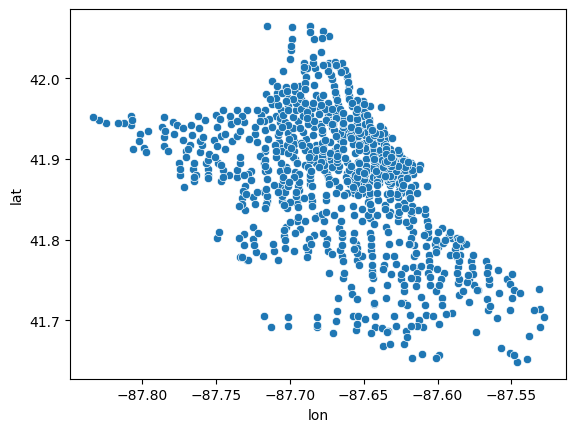

In [306]:
sns.scatterplot(x=stations_df_red["lon"],y=stations_df_red["lat"])

In [302]:
from folium import Icon

map = Map([41.8781, -87.6298], zoom_start=11)

for point in range(0, len(stations_df_red)):
    
    lat = stations_df.loc[point,"lat"]
    lon = stations_df.loc[point,"lon"]

    Marker(location=[lat, lon],
           icon=Icon(color='blue', icon="dot", prefix='fa', size=(3,3)),
           popup=stations_df_red.loc[point,'station_id']).add_to(map)
map